In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

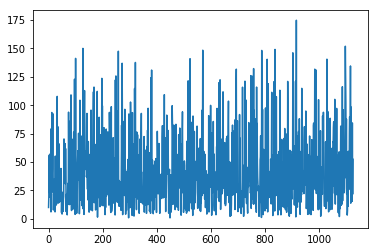

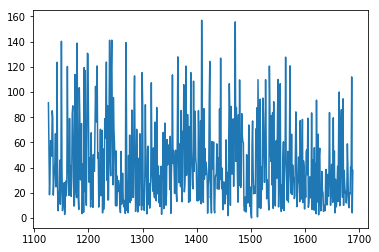

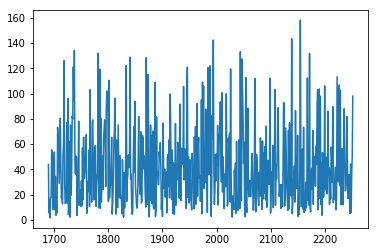

In [2]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index()

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df):
    return (np.array(df[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                         'tgrad', 'pressure', 'pluvio']]),\
            np.array(df['NO2_ref']))

        
df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

def dataframe_to_xy_sequences(df, sequence_size):
    out_X = np.zeros((len(df)//sequence_size, sequence_size, 8))
    out_y = np.zeros((len(df)//sequence_size, sequence_size))
    i = 0
    while i + sequence_size < len(df):
        sequence = df.iloc[i:i+sequence_size]
        out_X[i//sequence_size] =  np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']])
        out_y[i//sequence_size] = np.array(sequence['NO2_ref'])
        i += sequence_size
        
    return out_X, out_y

plt.plot(df_train['NO2_ref'])
plt.show()

plt.plot(df_valid['NO2_ref'])
plt.show()

plt.plot(df_test['NO2_ref'])
plt.show()

In [3]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim, recurrent_dropout=1))#, recurrent_dropout=1))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


In [4]:
print(X_train.shape)
model = simple_rnn_model(32, X_train.shape[1:])

(1126, 1, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [5]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=True)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 0s 425us/step - loss: 2657.3060 - val_loss: 2830.1846
Epoch 2/10000
1126/1126 [==============================] - 0s 54us/step - loss: 2635.1408 - val_loss: 2803.1331
Epoch 3/10000
1126/1126 [==============================] - 0s 52us/step - loss: 2605.6450 - val_loss: 2765.2119
Epoch 4/10000
1126/1126 [==============================] - 0s 46us/step - loss: 2566.2363 - val_loss: 2718.5837
Epoch 5/10000
1126/1126 [==============================] - 0s 48us/step - loss: 2518.1728 - val_loss: 2659.2966
Epoch 6/10000
1126/1126 [==============================] - 0s 49us/step - loss: 2458.8639 - val_loss: 2592.9371
Epoch 7/10000
1126/1126 [==============================] - 0s 46us/step - loss: 2392.5453 - val_loss: 2517.4421
Epoch 8/10000
1126/1126 [==============================] - 0s 49us/step - loss: 2318.0120 - val_loss: 2435.5293
Epoch 9/10000
1126/1126 [==============================]

Epoch 74/10000
1126/1126 [==============================] - 0s 43us/step - loss: 274.0385 - val_loss: 297.7249
Epoch 75/10000
1126/1126 [==============================] - 0s 47us/step - loss: 269.1666 - val_loss: 292.1178
Epoch 76/10000
1126/1126 [==============================] - 0s 45us/step - loss: 264.4418 - val_loss: 287.0179
Epoch 77/10000
1126/1126 [==============================] - 0s 45us/step - loss: 260.0244 - val_loss: 281.7569
Epoch 78/10000
1126/1126 [==============================] - 0s 49us/step - loss: 255.3165 - val_loss: 277.2134
Epoch 79/10000
1126/1126 [==============================] - 0s 44us/step - loss: 250.9277 - val_loss: 272.1111
Epoch 80/10000
1126/1126 [==============================] - 0s 49us/step - loss: 246.6527 - val_loss: 267.5360
Epoch 81/10000
1126/1126 [==============================] - 0s 48us/step - loss: 242.6067 - val_loss: 262.9692
Epoch 82/10000
1126/1126 [==============================] - 0s 46us/step - loss: 238.6672 - val_loss: 258.6268
E

1126/1126 [==============================] - 0s 49us/step - loss: 117.1567 - val_loss: 125.2433
Epoch 148/10000
1126/1126 [==============================] - 0s 49us/step - loss: 116.2387 - val_loss: 124.3885
Epoch 149/10000
1126/1126 [==============================] - 0s 45us/step - loss: 115.1351 - val_loss: 122.8796
Epoch 150/10000
1126/1126 [==============================] - 0s 48us/step - loss: 114.3626 - val_loss: 121.6099
Epoch 151/10000
1126/1126 [==============================] - 0s 52us/step - loss: 113.2839 - val_loss: 120.8297
Epoch 152/10000
1126/1126 [==============================] - 0s 55us/step - loss: 112.2846 - val_loss: 120.0660
Epoch 153/10000
1126/1126 [==============================] - 0s 52us/step - loss: 111.4628 - val_loss: 118.9233
Epoch 154/10000
1126/1126 [==============================] - 0s 54us/step - loss: 110.4988 - val_loss: 117.9811
Epoch 155/10000
1126/1126 [==============================] - 0s 53us/step - loss: 109.6061 - val_loss: 117.1555
Epoch 15

1126/1126 [==============================] - 0s 46us/step - loss: 68.5805 - val_loss: 76.7260
Epoch 222/10000
1126/1126 [==============================] - 0s 47us/step - loss: 68.2875 - val_loss: 76.7484
Epoch 223/10000
1126/1126 [==============================] - 0s 45us/step - loss: 67.8565 - val_loss: 76.1013
Epoch 224/10000
1126/1126 [==============================] - 0s 49us/step - loss: 67.5568 - val_loss: 75.7613
Epoch 225/10000
1126/1126 [==============================] - 0s 47us/step - loss: 67.3618 - val_loss: 75.5391
Epoch 226/10000
1126/1126 [==============================] - 0s 54us/step - loss: 67.0223 - val_loss: 75.3295
Epoch 227/10000
1126/1126 [==============================] - 0s 47us/step - loss: 66.6943 - val_loss: 75.2093
Epoch 228/10000
1126/1126 [==============================] - 0s 46us/step - loss: 66.3943 - val_loss: 74.9293
Epoch 229/10000
1126/1126 [==============================] - 0s 45us/step - loss: 66.1534 - val_loss: 74.5761
Epoch 230/10000
1126/1126 

1126/1126 [==============================] - 0s 43us/step - loss: 56.1700 - val_loss: 66.8613
Epoch 296/10000
1126/1126 [==============================] - 0s 43us/step - loss: 56.1598 - val_loss: 66.8761
Epoch 297/10000
1126/1126 [==============================] - 0s 44us/step - loss: 56.0605 - val_loss: 66.2325
Epoch 298/10000
1126/1126 [==============================] - 0s 44us/step - loss: 56.1040 - val_loss: 66.3686
Epoch 299/10000
1126/1126 [==============================] - 0s 44us/step - loss: 56.0192 - val_loss: 66.0889
Epoch 300/10000
1126/1126 [==============================] - 0s 47us/step - loss: 55.9524 - val_loss: 66.8988
Epoch 301/10000
1126/1126 [==============================] - 0s 48us/step - loss: 55.6880 - val_loss: 66.1721
Epoch 302/10000
1126/1126 [==============================] - 0s 44us/step - loss: 55.6656 - val_loss: 66.3735
Epoch 303/10000
1126/1126 [==============================] - 0s 44us/step - loss: 55.6626 - val_loss: 65.5889
Epoch 304/10000
1126/1126 

1126/1126 [==============================] - 0s 48us/step - loss: 51.4893 - val_loss: 63.5040
Epoch 370/10000
1126/1126 [==============================] - 0s 48us/step - loss: 51.6628 - val_loss: 62.9484
Epoch 371/10000
1126/1126 [==============================] - 0s 48us/step - loss: 51.3635 - val_loss: 62.9379
Epoch 372/10000
1126/1126 [==============================] - 0s 46us/step - loss: 51.4627 - val_loss: 62.6831
Epoch 373/10000
1126/1126 [==============================] - 0s 46us/step - loss: 51.2707 - val_loss: 62.9957
Epoch 374/10000
1126/1126 [==============================] - 0s 47us/step - loss: 51.1859 - val_loss: 62.6501
Epoch 375/10000
1126/1126 [==============================] - 0s 47us/step - loss: 51.0356 - val_loss: 62.7469
Epoch 376/10000
1126/1126 [==============================] - 0s 47us/step - loss: 51.0397 - val_loss: 62.4291
Epoch 377/10000
1126/1126 [==============================] - 0s 48us/step - loss: 51.4172 - val_loss: 62.7288
Epoch 378/10000
1126/1126 

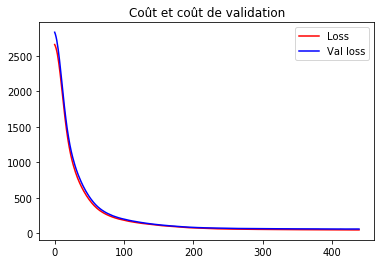

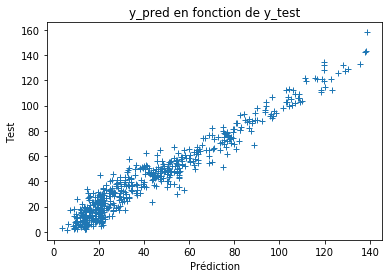

In [6]:
y_pred = model.predict(X_test, batch_size=32)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [7]:
model = lstm_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 1s 947us/step - loss: 2663.2927 - val_loss: 2844.8130
Epoch 2/10000
1126/1126 [==============================] - 0s 81us/step - loss: 2650.6371 - val_loss: 2826.9805
Epoch 3/10000
1126/1126 [==============================] - 0s 84us/step - loss: 2628.0872 - val_loss: 2796.0003
Epoch 4/10000
1126/1126 [==============================] - 0s 83us/step - loss: 2592.2885 - val_loss: 2750.3634
Epoch 5/10000
1126/1126 [==============================] - 0s 85us/step - loss: 2544.1755 - val_loss: 2693.6121
Epoch 6/10000
1126/1126 [==============================] - 0s 88us/step - loss: 2487.7276 - val_loss: 2630.9352
Epoch 7/10000
1126/1126 [==============================] - 0s 85us/step - loss: 2426.5669 - val_loss: 2565.0463
Epoch 8/10000
1126/1126 [==============================] - 0s 73us/step - loss: 2362.5951 - val_loss: 2497.6462
Epoch 9/10000
1126/1126 [==============================]

Epoch 74/10000
1126/1126 [==============================] - 0s 92us/step - loss: 352.4056 - val_loss: 385.5379
Epoch 75/10000
1126/1126 [==============================] - 0s 95us/step - loss: 345.3161 - val_loss: 377.7618
Epoch 76/10000
1126/1126 [==============================] - 0s 75us/step - loss: 338.4892 - val_loss: 370.2767
Epoch 77/10000
1126/1126 [==============================] - 0s 76us/step - loss: 331.9091 - val_loss: 363.0607
Epoch 78/10000
1126/1126 [==============================] - 0s 78us/step - loss: 325.5639 - val_loss: 356.1026
Epoch 79/10000
1126/1126 [==============================] - 0s 74us/step - loss: 319.4508 - val_loss: 349.3936
Epoch 80/10000
1126/1126 [==============================] - 0s 74us/step - loss: 313.5572 - val_loss: 342.9213
Epoch 81/10000
1126/1126 [==============================] - 0s 74us/step - loss: 307.8683 - val_loss: 336.6754
Epoch 82/10000
1126/1126 [==============================] - 0s 73us/step - loss: 302.3732 - val_loss: 330.6395
E

1126/1126 [==============================] - 0s 92us/step - loss: 125.8543 - val_loss: 138.8469
Epoch 148/10000
1126/1126 [==============================] - 0s 89us/step - loss: 124.3888 - val_loss: 137.3354
Epoch 149/10000
1126/1126 [==============================] - 0s 90us/step - loss: 122.9468 - val_loss: 135.8602
Epoch 150/10000
1126/1126 [==============================] - 0s 98us/step - loss: 121.5305 - val_loss: 134.4006
Epoch 151/10000
1126/1126 [==============================] - 0s 90us/step - loss: 120.1397 - val_loss: 132.9474
Epoch 152/10000
1126/1126 [==============================] - 0s 98us/step - loss: 118.7751 - val_loss: 131.5457
Epoch 153/10000
1126/1126 [==============================] - 0s 85us/step - loss: 117.4361 - val_loss: 130.1769
Epoch 154/10000
1126/1126 [==============================] - 0s 72us/step - loss: 116.1221 - val_loss: 128.8090
Epoch 155/10000
1126/1126 [==============================] - 0s 71us/step - loss: 114.8289 - val_loss: 127.4856
Epoch 15

1126/1126 [==============================] - 0s 68us/step - loss: 66.2391 - val_loss: 76.0691
Epoch 222/10000
1126/1126 [==============================] - 0s 71us/step - loss: 65.8504 - val_loss: 75.7146
Epoch 223/10000
1126/1126 [==============================] - 0s 72us/step - loss: 65.4736 - val_loss: 75.3311
Epoch 224/10000
1126/1126 [==============================] - 0s 72us/step - loss: 65.1016 - val_loss: 74.9550
Epoch 225/10000
1126/1126 [==============================] - 0s 69us/step - loss: 64.7276 - val_loss: 74.6058
Epoch 226/10000
1126/1126 [==============================] - 0s 71us/step - loss: 64.3723 - val_loss: 74.2307
Epoch 227/10000
1126/1126 [==============================] - 0s 67us/step - loss: 64.0063 - val_loss: 73.9153
Epoch 228/10000
1126/1126 [==============================] - 0s 65us/step - loss: 63.6571 - val_loss: 73.5588
Epoch 229/10000
1126/1126 [==============================] - 0s 71us/step - loss: 63.2981 - val_loss: 73.2260
Epoch 230/10000
1126/1126 

1126/1126 [==============================] - 0s 68us/step - loss: 48.9352 - val_loss: 60.4816
Epoch 296/10000
1126/1126 [==============================] - 0s 71us/step - loss: 48.7971 - val_loss: 60.3807
Epoch 297/10000
1126/1126 [==============================] - 0s 65us/step - loss: 48.6709 - val_loss: 60.2647
Epoch 298/10000
1126/1126 [==============================] - 0s 65us/step - loss: 48.5418 - val_loss: 60.1557
Epoch 299/10000
1126/1126 [==============================] - 0s 71us/step - loss: 48.4114 - val_loss: 60.0519
Epoch 300/10000
1126/1126 [==============================] - 0s 78us/step - loss: 48.2861 - val_loss: 59.9521
Epoch 301/10000
1126/1126 [==============================] - 0s 93us/step - loss: 48.1587 - val_loss: 59.8471
Epoch 302/10000
1126/1126 [==============================] - 0s 87us/step - loss: 48.0406 - val_loss: 59.7475
Epoch 303/10000
1126/1126 [==============================] - 0s 82us/step - loss: 47.9203 - val_loss: 59.6510
Epoch 304/10000
1126/1126 

1126/1126 [==============================] - 0s 78us/step - loss: 42.6942 - val_loss: 55.2719
Epoch 370/10000
1126/1126 [==============================] - 0s 75us/step - loss: 42.6359 - val_loss: 55.1802
Epoch 371/10000
1126/1126 [==============================] - 0s 72us/step - loss: 42.5799 - val_loss: 55.1686
Epoch 372/10000
1126/1126 [==============================] - 0s 78us/step - loss: 42.5209 - val_loss: 55.0908
Epoch 373/10000
1126/1126 [==============================] - 0s 76us/step - loss: 42.4685 - val_loss: 55.0705
Epoch 374/10000
1126/1126 [==============================] - 0s 72us/step - loss: 42.4113 - val_loss: 54.9906
Epoch 375/10000
1126/1126 [==============================] - 0s 71us/step - loss: 42.3595 - val_loss: 54.9612
Epoch 376/10000
1126/1126 [==============================] - 0s 67us/step - loss: 42.3040 - val_loss: 54.8821
Epoch 377/10000
1126/1126 [==============================] - 0s 66us/step - loss: 42.2462 - val_loss: 54.8598
Epoch 378/10000
1126/1126 

1126/1126 [==============================] - 0s 76us/step - loss: 39.3432 - val_loss: 52.0375
Epoch 444/10000
1126/1126 [==============================] - 0s 71us/step - loss: 39.3048 - val_loss: 51.9951
Epoch 445/10000
1126/1126 [==============================] - 0s 78us/step - loss: 39.2645 - val_loss: 51.9798
Epoch 446/10000
1126/1126 [==============================] - 0s 95us/step - loss: 39.2287 - val_loss: 51.9117
Epoch 447/10000
1126/1126 [==============================] - 0s 83us/step - loss: 39.1896 - val_loss: 51.9152
Epoch 448/10000
1126/1126 [==============================] - 0s 72us/step - loss: 39.1495 - val_loss: 51.8681
Epoch 449/10000
1126/1126 [==============================] - 0s 84us/step - loss: 39.1075 - val_loss: 51.8493
Epoch 450/10000
1126/1126 [==============================] - 0s 78us/step - loss: 39.0688 - val_loss: 51.8107
Epoch 451/10000
1126/1126 [==============================] - 0s 89us/step - loss: 39.0237 - val_loss: 51.8043
Epoch 452/10000
1126/1126 

1126/1126 [==============================] - 0s 101us/step - loss: 36.7643 - val_loss: 49.5754
Epoch 518/10000
1126/1126 [==============================] - 0s 93us/step - loss: 36.7357 - val_loss: 49.5311
Epoch 519/10000
1126/1126 [==============================] - 0s 98us/step - loss: 36.7069 - val_loss: 49.5086
Epoch 520/10000
1126/1126 [==============================] - 0s 85us/step - loss: 36.6749 - val_loss: 49.4669
Epoch 521/10000
1126/1126 [==============================] - 0s 97us/step - loss: 36.6460 - val_loss: 49.4459
Epoch 522/10000
1126/1126 [==============================] - 0s 82us/step - loss: 36.6183 - val_loss: 49.4079
Epoch 523/10000
1126/1126 [==============================] - 0s 81us/step - loss: 36.5844 - val_loss: 49.3815
Epoch 524/10000
1126/1126 [==============================] - 0s 92us/step - loss: 36.5560 - val_loss: 49.3344
Epoch 525/10000
1126/1126 [==============================] - 0s 88us/step - loss: 36.5253 - val_loss: 49.3252
Epoch 526/10000
1126/1126

1126/1126 [==============================] - 0s 83us/step - loss: 34.6343 - val_loss: 47.7852
Epoch 592/10000
1126/1126 [==============================] - 0s 96us/step - loss: 34.6121 - val_loss: 47.7493
Epoch 593/10000
1126/1126 [==============================] - 0s 96us/step - loss: 34.5840 - val_loss: 47.7415
Epoch 594/10000
1126/1126 [==============================] - 0s 93us/step - loss: 34.5586 - val_loss: 47.7070
Epoch 595/10000
1126/1126 [==============================] - 0s 97us/step - loss: 34.5303 - val_loss: 47.6898
Epoch 596/10000
1126/1126 [==============================] - 0s 103us/step - loss: 34.5053 - val_loss: 47.6594
Epoch 597/10000
1126/1126 [==============================] - 0s 89us/step - loss: 34.4785 - val_loss: 47.6474
Epoch 598/10000
1126/1126 [==============================] - 0s 89us/step - loss: 34.4514 - val_loss: 47.6144
Epoch 599/10000
1126/1126 [==============================] - 0s 92us/step - loss: 34.4247 - val_loss: 47.6060
Epoch 600/10000
1126/1126

1126/1126 [==============================] - 0s 77us/step - loss: 32.9036 - val_loss: 46.3091
Epoch 666/10000
1126/1126 [==============================] - 0s 72us/step - loss: 32.8860 - val_loss: 46.2824
Epoch 667/10000
1126/1126 [==============================] - 0s 75us/step - loss: 32.8604 - val_loss: 46.2797
Epoch 668/10000
1126/1126 [==============================] - 0s 79us/step - loss: 32.8392 - val_loss: 46.2428
Epoch 669/10000
1126/1126 [==============================] - 0s 78us/step - loss: 32.8158 - val_loss: 46.2400
Epoch 670/10000
1126/1126 [==============================] - 0s 85us/step - loss: 32.7945 - val_loss: 46.2132
Epoch 671/10000
1126/1126 [==============================] - 0s 78us/step - loss: 32.7725 - val_loss: 46.2065
Epoch 672/10000
1126/1126 [==============================] - 0s 78us/step - loss: 32.7536 - val_loss: 46.1850
Epoch 673/10000
1126/1126 [==============================] - 0s 72us/step - loss: 32.7271 - val_loss: 46.1785
Epoch 674/10000
1126/1126 

1126/1126 [==============================] - 0s 78us/step - loss: 31.3583 - val_loss: 45.1415
Epoch 740/10000
1126/1126 [==============================] - 0s 85us/step - loss: 31.3390 - val_loss: 45.1198
Epoch 741/10000
1126/1126 [==============================] - 0s 91us/step - loss: 31.3175 - val_loss: 45.1134
Epoch 742/10000
1126/1126 [==============================] - 0s 86us/step - loss: 31.2980 - val_loss: 45.0898
Epoch 743/10000
1126/1126 [==============================] - ETA: 0s - loss: 29.85 - 0s 90us/step - loss: 31.2788 - val_loss: 45.0822
Epoch 744/10000
1126/1126 [==============================] - 0s 102us/step - loss: 31.2619 - val_loss: 45.0663
Epoch 745/10000
1126/1126 [==============================] - 0s 95us/step - loss: 31.2385 - val_loss: 45.0547
Epoch 746/10000
1126/1126 [==============================] - 0s 91us/step - loss: 31.2196 - val_loss: 45.0337
Epoch 747/10000
1126/1126 [==============================] - 0s 84us/step - loss: 31.2021 - val_loss: 45.0308
E

1126/1126 [==============================] - 0s 71us/step - loss: 29.8721 - val_loss: 44.4224
Epoch 814/10000
1126/1126 [==============================] - 0s 69us/step - loss: 29.8519 - val_loss: 44.3982
Epoch 815/10000
1126/1126 [==============================] - 0s 68us/step - loss: 29.8357 - val_loss: 44.4137
Epoch 816/10000
1126/1126 [==============================] - 0s 69us/step - loss: 29.8178 - val_loss: 44.3940
Epoch 817/10000
1126/1126 [==============================] - 0s 70us/step - loss: 29.7977 - val_loss: 44.3844
Epoch 818/10000
1126/1126 [==============================] - 0s 80us/step - loss: 29.7834 - val_loss: 44.3776
Epoch 819/10000
1126/1126 [==============================] - 0s 71us/step - loss: 29.7677 - val_loss: 44.3825
Epoch 820/10000
1126/1126 [==============================] - 0s 66us/step - loss: 29.7442 - val_loss: 44.3628
Epoch 821/10000
1126/1126 [==============================] - 0s 75us/step - loss: 29.7287 - val_loss: 44.3663
Epoch 822/10000
1126/1126 

1126/1126 [==============================] - 0s 83us/step - loss: 28.6833 - val_loss: 43.9412
Epoch 888/10000
1126/1126 [==============================] - ETA: 0s - loss: 27.59 - 0s 92us/step - loss: 28.6675 - val_loss: 43.9255
Epoch 889/10000
1126/1126 [==============================] - 0s 85us/step - loss: 28.6554 - val_loss: 43.9220
Epoch 890/10000
1126/1126 [==============================] - 0s 81us/step - loss: 28.6403 - val_loss: 43.9181
Epoch 891/10000
1126/1126 [==============================] - 0s 88us/step - loss: 28.6279 - val_loss: 43.9302
Epoch 892/10000
1126/1126 [==============================] - 0s 83us/step - loss: 28.6151 - val_loss: 43.9074
Epoch 893/10000
1126/1126 [==============================] - 0s 72us/step - loss: 28.6014 - val_loss: 43.9117
Epoch 894/10000
1126/1126 [==============================] - 0s 75us/step - loss: 28.5886 - val_loss: 43.8876
Epoch 895/10000
1126/1126 [==============================] - 0s 78us/step - loss: 28.5735 - val_loss: 43.8948
Ep

1126/1126 [==============================] - 0s 68us/step - loss: 27.7002 - val_loss: 43.6604
Epoch 962/10000
1126/1126 [==============================] - 0s 72us/step - loss: 27.6876 - val_loss: 43.6563
Epoch 963/10000
1126/1126 [==============================] - 0s 76us/step - loss: 27.6752 - val_loss: 43.6614
Epoch 964/10000
1126/1126 [==============================] - 0s 91us/step - loss: 27.6649 - val_loss: 43.6479
Epoch 965/10000
1126/1126 [==============================] - 0s 88us/step - loss: 27.6503 - val_loss: 43.6511
Epoch 966/10000
1126/1126 [==============================] - 0s 77us/step - loss: 27.6372 - val_loss: 43.6367
Epoch 967/10000
1126/1126 [==============================] - 0s 77us/step - loss: 27.6260 - val_loss: 43.6481
Epoch 968/10000
1126/1126 [==============================] - 0s 83us/step - loss: 27.6143 - val_loss: 43.6415
Epoch 969/10000
1126/1126 [==============================] - 0s 79us/step - loss: 27.6001 - val_loss: 43.6392
Epoch 970/10000
1126/1126 

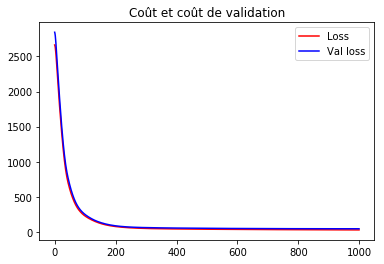

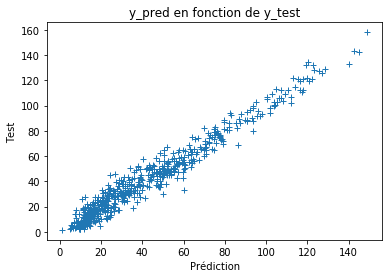

In [9]:
y_pred = model.predict(X_test)
y_test.reshape(len(y_test))
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [10]:
model = gru_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 1s 862us/step - loss: 2662.8500 - val_loss: 2843.3986
Epoch 2/10000
1126/1126 [==============================] - 0s 64us/step - loss: 2647.3507 - val_loss: 2821.2803
Epoch 3/10000
1126/1126 [==============================] - 0s 67us/step - loss: 2619.0733 - val_loss: 2782.8609
Epoch 4/10000
1126/1126 [==============================] - 0s 70us/step - loss: 2575.1069 - val_loss: 2727.9686
Epoch 5/10000
1126/1126 [==============================] - 0s 72us/step - loss: 2516.6818 - val_loss: 2659.3359
Epoch 6/10000
1126/1126 [==============================] - 0s 73us/step - loss: 2447.0127 - val_loss: 2581.3906
Epoch 7/10000
1126/1126 [==============================] - 0s 74us/step - loss: 2370.2164 - val_loss: 2498.3023
Epoch 8/10000
1126/1126 [==============================] - 0s 68us/step - loss: 2289.6000 - val_loss: 2412.9464
Epoch 9/10000
1126/1126 [==============================]

Epoch 74/10000
1126/1126 [==============================] - 0s 59us/step - loss: 240.0449 - val_loss: 262.1185
Epoch 75/10000
1126/1126 [==============================] - 0s 62us/step - loss: 235.5821 - val_loss: 257.2102
Epoch 76/10000
1126/1126 [==============================] - 0s 62us/step - loss: 231.3042 - val_loss: 252.5049
Epoch 77/10000
1126/1126 [==============================] - 0s 62us/step - loss: 227.2038 - val_loss: 247.9993
Epoch 78/10000
1126/1126 [==============================] - 0s 61us/step - loss: 223.2796 - val_loss: 243.6816
Epoch 79/10000
1126/1126 [==============================] - 0s 63us/step - loss: 219.5139 - val_loss: 239.5389
Epoch 80/10000
1126/1126 [==============================] - 0s 60us/step - loss: 215.9007 - val_loss: 235.5650
Epoch 81/10000
1126/1126 [==============================] - 0s 63us/step - loss: 212.4345 - val_loss: 231.7507
Epoch 82/10000
1126/1126 [==============================] - 0s 69us/step - loss: 209.1052 - val_loss: 228.0806
E

1126/1126 [==============================] - 0s 61us/step - loss: 95.2088 - val_loss: 104.7288
Epoch 148/10000
1126/1126 [==============================] - 0s 63us/step - loss: 94.2583 - val_loss: 103.7167
Epoch 149/10000
1126/1126 [==============================] - 0s 60us/step - loss: 93.3323 - val_loss: 102.7403
Epoch 150/10000
1126/1126 [==============================] - 0s 61us/step - loss: 92.4265 - val_loss: 101.7897
Epoch 151/10000
1126/1126 [==============================] - 0s 60us/step - loss: 91.5426 - val_loss: 100.8633
Epoch 152/10000
1126/1126 [==============================] - 0s 64us/step - loss: 90.6798 - val_loss: 99.9509
Epoch 153/10000
1126/1126 [==============================] - 0s 61us/step - loss: 89.8387 - val_loss: 99.0541
Epoch 154/10000
1126/1126 [==============================] - 0s 62us/step - loss: 89.0105 - val_loss: 98.1861
Epoch 155/10000
1126/1126 [==============================] - 0s 60us/step - loss: 88.2027 - val_loss: 97.3321
Epoch 156/10000
1126/

1126/1126 [==============================] - 0s 70us/step - loss: 59.7070 - val_loss: 69.0011
Epoch 222/10000
1126/1126 [==============================] - 0s 64us/step - loss: 59.4964 - val_loss: 68.8145
Epoch 223/10000
1126/1126 [==============================] - 0s 60us/step - loss: 59.2915 - val_loss: 68.6257
Epoch 224/10000
1126/1126 [==============================] - 0s 62us/step - loss: 59.0892 - val_loss: 68.4344
Epoch 225/10000
1126/1126 [==============================] - 0s 63us/step - loss: 58.8924 - val_loss: 68.2597
Epoch 226/10000
1126/1126 [==============================] - 0s 62us/step - loss: 58.7011 - val_loss: 68.0702
Epoch 227/10000
1126/1126 [==============================] - 0s 62us/step - loss: 58.5026 - val_loss: 67.9172
Epoch 228/10000
1126/1126 [==============================] - 0s 63us/step - loss: 58.3114 - val_loss: 67.7305
Epoch 229/10000
1126/1126 [==============================] - 0s 60us/step - loss: 58.1187 - val_loss: 67.5754
Epoch 230/10000
1126/1126 

1126/1126 [==============================] - 0s 59us/step - loss: 49.9520 - val_loss: 60.2860
Epoch 296/10000
1126/1126 [==============================] - 0s 61us/step - loss: 49.8785 - val_loss: 60.2154
Epoch 297/10000
1126/1126 [==============================] - 0s 60us/step - loss: 49.7988 - val_loss: 60.1481
Epoch 298/10000
1126/1126 [==============================] - 0s 64us/step - loss: 49.7248 - val_loss: 60.0948
Epoch 299/10000
1126/1126 [==============================] - 0s 61us/step - loss: 49.6443 - val_loss: 60.0224
Epoch 300/10000
1126/1126 [==============================] - 0s 61us/step - loss: 49.5679 - val_loss: 59.9649
Epoch 301/10000
1126/1126 [==============================] - 0s 61us/step - loss: 49.4923 - val_loss: 59.9025
Epoch 302/10000
1126/1126 [==============================] - 0s 60us/step - loss: 49.4181 - val_loss: 59.8401
Epoch 303/10000
1126/1126 [==============================] - 0s 60us/step - loss: 49.3447 - val_loss: 59.7704
Epoch 304/10000
1126/1126 

1126/1126 [==============================] - 0s 65us/step - loss: 45.8057 - val_loss: 56.6892
Epoch 370/10000
1126/1126 [==============================] - 0s 60us/step - loss: 45.7627 - val_loss: 56.6422
Epoch 371/10000
1126/1126 [==============================] - 0s 60us/step - loss: 45.7162 - val_loss: 56.6037
Epoch 372/10000
1126/1126 [==============================] - 0s 60us/step - loss: 45.6795 - val_loss: 56.5663
Epoch 373/10000
1126/1126 [==============================] - 0s 69us/step - loss: 45.6359 - val_loss: 56.5224
Epoch 374/10000
1126/1126 [==============================] - 0s 67us/step - loss: 45.5918 - val_loss: 56.4855
Epoch 375/10000
1126/1126 [==============================] - 0s 66us/step - loss: 45.5506 - val_loss: 56.4465
Epoch 376/10000
1126/1126 [==============================] - 0s 67us/step - loss: 45.5131 - val_loss: 56.4126
Epoch 377/10000
1126/1126 [==============================] - 0s 69us/step - loss: 45.4706 - val_loss: 56.3755
Epoch 378/10000
1126/1126 

1126/1126 [==============================] - 0s 69us/step - loss: 43.0378 - val_loss: 54.0736
Epoch 444/10000
1126/1126 [==============================] - 0s 83us/step - loss: 43.0060 - val_loss: 54.0444
Epoch 445/10000
1126/1126 [==============================] - 0s 77us/step - loss: 42.9740 - val_loss: 54.0118
Epoch 446/10000
1126/1126 [==============================] - 0s 68us/step - loss: 42.9413 - val_loss: 53.9837
Epoch 447/10000
1126/1126 [==============================] - 0s 65us/step - loss: 42.9073 - val_loss: 53.9394
Epoch 448/10000
1126/1126 [==============================] - 0s 65us/step - loss: 42.8799 - val_loss: 53.9191
Epoch 449/10000
1126/1126 [==============================] - 0s 68us/step - loss: 42.8436 - val_loss: 53.8880
Epoch 450/10000
1126/1126 [==============================] - 0s 70us/step - loss: 42.8156 - val_loss: 53.8609
Epoch 451/10000
1126/1126 [==============================] - 0s 70us/step - loss: 42.7819 - val_loss: 53.8296
Epoch 452/10000
1126/1126 

1126/1126 [==============================] - 0s 75us/step - loss: 40.7148 - val_loss: 51.8219
Epoch 518/10000
1126/1126 [==============================] - 0s 72us/step - loss: 40.6801 - val_loss: 51.7888
Epoch 519/10000
1126/1126 [==============================] - 0s 75us/step - loss: 40.6512 - val_loss: 51.7632
Epoch 520/10000
1126/1126 [==============================] - 0s 70us/step - loss: 40.6192 - val_loss: 51.7321
Epoch 521/10000
1126/1126 [==============================] - 0s 72us/step - loss: 40.5859 - val_loss: 51.7079
Epoch 522/10000
1126/1126 [==============================] - 0s 73us/step - loss: 40.5559 - val_loss: 51.6804
Epoch 523/10000
1126/1126 [==============================] - 0s 65us/step - loss: 40.5241 - val_loss: 51.6554
Epoch 524/10000
1126/1126 [==============================] - 0s 63us/step - loss: 40.4963 - val_loss: 51.6198
Epoch 525/10000
1126/1126 [==============================] - 0s 65us/step - loss: 40.4624 - val_loss: 51.5830
Epoch 526/10000
1126/1126 

1126/1126 [==============================] - 0s 67us/step - loss: 38.6256 - val_loss: 50.0131
Epoch 592/10000
1126/1126 [==============================] - 0s 64us/step - loss: 38.6009 - val_loss: 49.9949
Epoch 593/10000
1126/1126 [==============================] - 0s 66us/step - loss: 38.5754 - val_loss: 49.9797
Epoch 594/10000
1126/1126 [==============================] - 0s 63us/step - loss: 38.5498 - val_loss: 49.9568
Epoch 595/10000
1126/1126 [==============================] - 0s 63us/step - loss: 38.5261 - val_loss: 49.9424
Epoch 596/10000
1126/1126 [==============================] - 0s 64us/step - loss: 38.4974 - val_loss: 49.9184
Epoch 597/10000
1126/1126 [==============================] - 0s 64us/step - loss: 38.4763 - val_loss: 49.9070
Epoch 598/10000
1126/1126 [==============================] - 0s 62us/step - loss: 38.4478 - val_loss: 49.8791
Epoch 599/10000
1126/1126 [==============================] - 0s 65us/step - loss: 38.4267 - val_loss: 49.8683
Epoch 600/10000
1126/1126 

1126/1126 [==============================] - 0s 64us/step - loss: 36.8953 - val_loss: 48.8123
Epoch 666/10000
1126/1126 [==============================] - 0s 64us/step - loss: 36.8702 - val_loss: 48.7994
Epoch 667/10000
1126/1126 [==============================] - 0s 65us/step - loss: 36.8476 - val_loss: 48.7876
Epoch 668/10000
1126/1126 [==============================] - 0s 64us/step - loss: 36.8265 - val_loss: 48.7835
Epoch 669/10000
1126/1126 [==============================] - 0s 66us/step - loss: 36.8038 - val_loss: 48.7734
Epoch 670/10000
1126/1126 [==============================] - 0s 64us/step - loss: 36.7791 - val_loss: 48.7605
Epoch 671/10000
1126/1126 [==============================] - 0s 64us/step - loss: 36.7606 - val_loss: 48.7474
Epoch 672/10000
1126/1126 [==============================] - 0s 64us/step - loss: 36.7341 - val_loss: 48.7354
Epoch 673/10000
1126/1126 [==============================] - 0s 65us/step - loss: 36.7120 - val_loss: 48.7264
Epoch 674/10000
1126/1126 

1126/1126 [==============================] - 0s 64us/step - loss: 35.4250 - val_loss: 47.6788
Epoch 740/10000
1126/1126 [==============================] - 0s 65us/step - loss: 35.4070 - val_loss: 47.6563
Epoch 741/10000
1126/1126 [==============================] - 0s 67us/step - loss: 35.3875 - val_loss: 47.6386
Epoch 742/10000
1126/1126 [==============================] - 0s 62us/step - loss: 35.3708 - val_loss: 47.6141
Epoch 743/10000
1126/1126 [==============================] - 0s 63us/step - loss: 35.3520 - val_loss: 47.6043
Epoch 744/10000
1126/1126 [==============================] - 0s 66us/step - loss: 35.3355 - val_loss: 47.5849
Epoch 745/10000
1126/1126 [==============================] - 0s 64us/step - loss: 35.3169 - val_loss: 47.5806
Epoch 746/10000
1126/1126 [==============================] - 0s 63us/step - loss: 35.2987 - val_loss: 47.5559
Epoch 747/10000
1126/1126 [==============================] - 0s 64us/step - loss: 35.2797 - val_loss: 47.5425
Epoch 748/10000
1126/1126 

1126/1126 [==============================] - 0s 68us/step - loss: 34.1751 - val_loss: 46.8220
Epoch 814/10000
1126/1126 [==============================] - 0s 63us/step - loss: 34.1598 - val_loss: 46.8045
Epoch 815/10000
1126/1126 [==============================] - 0s 66us/step - loss: 34.1442 - val_loss: 46.7980
Epoch 816/10000
1126/1126 [==============================] - 0s 68us/step - loss: 34.1296 - val_loss: 46.7946
Epoch 817/10000
1126/1126 [==============================] - 0s 63us/step - loss: 34.1140 - val_loss: 46.7870
Epoch 818/10000
1126/1126 [==============================] - 0s 66us/step - loss: 34.1002 - val_loss: 46.7806
Epoch 819/10000
1126/1126 [==============================] - 0s 63us/step - loss: 34.0846 - val_loss: 46.7645
Epoch 820/10000
1126/1126 [==============================] - 0s 64us/step - loss: 34.0713 - val_loss: 46.7607
Epoch 821/10000
1126/1126 [==============================] - 0s 64us/step - loss: 34.0584 - val_loss: 46.7566
Epoch 822/10000
1126/1126 

1126/1126 [==============================] - 0s 67us/step - loss: 33.0974 - val_loss: 46.1574
Epoch 888/10000
1126/1126 [==============================] - 0s 65us/step - loss: 33.0810 - val_loss: 46.1483
Epoch 889/10000
1126/1126 [==============================] - 0s 64us/step - loss: 33.0675 - val_loss: 46.1388
Epoch 890/10000
1126/1126 [==============================] - 0s 64us/step - loss: 33.0516 - val_loss: 46.1269
Epoch 891/10000
1126/1126 [==============================] - 0s 63us/step - loss: 33.0384 - val_loss: 46.1222
Epoch 892/10000
1126/1126 [==============================] - 0s 64us/step - loss: 33.0242 - val_loss: 46.1215
Epoch 893/10000
1126/1126 [==============================] - 0s 64us/step - loss: 33.0076 - val_loss: 46.1098
Epoch 894/10000
1126/1126 [==============================] - 0s 65us/step - loss: 32.9953 - val_loss: 46.1061
Epoch 895/10000
1126/1126 [==============================] - 0s 68us/step - loss: 32.9782 - val_loss: 46.0976
Epoch 896/10000
1126/1126 

1126/1126 [==============================] - 0s 72us/step - loss: 32.0455 - val_loss: 45.7118
Epoch 962/10000
1126/1126 [==============================] - 0s 68us/step - loss: 32.0299 - val_loss: 45.7096
Epoch 963/10000
1126/1126 [==============================] - 0s 78us/step - loss: 32.0177 - val_loss: 45.7052
Epoch 964/10000
1126/1126 [==============================] - 0s 76us/step - loss: 32.0037 - val_loss: 45.6928
Epoch 965/10000
1126/1126 [==============================] - 0s 68us/step - loss: 31.9904 - val_loss: 45.6914
Epoch 966/10000
1126/1126 [==============================] - 0s 71us/step - loss: 31.9760 - val_loss: 45.6875
Epoch 967/10000
1126/1126 [==============================] - 0s 71us/step - loss: 31.9648 - val_loss: 45.6787
Epoch 968/10000
1126/1126 [==============================] - 0s 76us/step - loss: 31.9504 - val_loss: 45.6675
Epoch 969/10000
1126/1126 [==============================] - 0s 81us/step - loss: 31.9385 - val_loss: 45.6652
Epoch 970/10000
1126/1126 

1126/1126 [==============================] - 0s 66us/step - loss: 31.1205 - val_loss: 45.4039
Epoch 1036/10000
1126/1126 [==============================] - 0s 63us/step - loss: 31.1071 - val_loss: 45.4056
Epoch 1037/10000
1126/1126 [==============================] - 0s 66us/step - loss: 31.0961 - val_loss: 45.4017
Epoch 1038/10000
1126/1126 [==============================] - 0s 65us/step - loss: 31.0860 - val_loss: 45.4085
Epoch 1039/10000
1126/1126 [==============================] - 0s 67us/step - loss: 31.0706 - val_loss: 45.4022
Epoch 1040/10000
1126/1126 [==============================] - 0s 63us/step - loss: 31.0618 - val_loss: 45.4016
Epoch 1041/10000
1126/1126 [==============================] - 0s 64us/step - loss: 31.0488 - val_loss: 45.3944
Epoch 1042/10000
1126/1126 [==============================] - 0s 67us/step - loss: 31.0392 - val_loss: 45.3969
Epoch 1043/10000
1126/1126 [==============================] - 0s 64us/step - loss: 31.0253 - val_loss: 45.3890
Epoch 1044/10000
1

Epoch 1109/10000
1126/1126 [==============================] - 0s 69us/step - loss: 30.2520 - val_loss: 45.0909
Epoch 1110/10000
1126/1126 [==============================] - 0s 71us/step - loss: 30.2405 - val_loss: 45.0966
Epoch 1111/10000
1126/1126 [==============================] - 0s 64us/step - loss: 30.2264 - val_loss: 45.0845
Epoch 1112/10000
1126/1126 [==============================] - 0s 67us/step - loss: 30.2202 - val_loss: 45.0824
Epoch 1113/10000
1126/1126 [==============================] - 0s 69us/step - loss: 30.2073 - val_loss: 45.0835
Epoch 1114/10000
1126/1126 [==============================] - 0s 77us/step - loss: 30.1956 - val_loss: 45.0807
Epoch 1115/10000
1126/1126 [==============================] - 0s 63us/step - loss: 30.1859 - val_loss: 45.0702
Epoch 1116/10000
1126/1126 [==============================] - 0s 58us/step - loss: 30.1746 - val_loss: 45.0723
Epoch 1117/10000
1126/1126 [==============================] - 0s 59us/step - loss: 30.1615 - val_loss: 45.0674
E

Epoch 1183/10000
1126/1126 [==============================] - 0s 73us/step - loss: 29.4448 - val_loss: 44.7664
Epoch 1184/10000
1126/1126 [==============================] - 0s 70us/step - loss: 29.4319 - val_loss: 44.7599
Epoch 1185/10000
1126/1126 [==============================] - 0s 71us/step - loss: 29.4216 - val_loss: 44.7615
Epoch 1186/10000
1126/1126 [==============================] - 0s 77us/step - loss: 29.4121 - val_loss: 44.7596
Epoch 1187/10000
1126/1126 [==============================] - 0s 67us/step - loss: 29.3987 - val_loss: 44.7464
Epoch 1188/10000
1126/1126 [==============================] - 0s 65us/step - loss: 29.3897 - val_loss: 44.7419
Epoch 1189/10000
1126/1126 [==============================] - 0s 66us/step - loss: 29.3777 - val_loss: 44.7344
Epoch 1190/10000
1126/1126 [==============================] - 0s 64us/step - loss: 29.3714 - val_loss: 44.7343
Epoch 1191/10000
1126/1126 [==============================] - 0s 70us/step - loss: 29.3570 - val_loss: 44.7347
E

Epoch 1257/10000
1126/1126 [==============================] - 0s 84us/step - loss: 28.6537 - val_loss: 44.5235
Epoch 1258/10000
1126/1126 [==============================] - 0s 76us/step - loss: 28.6419 - val_loss: 44.5185
Epoch 1259/10000
1126/1126 [==============================] - 0s 87us/step - loss: 28.6323 - val_loss: 44.5213
Epoch 1260/10000
1126/1126 [==============================] - 0s 78us/step - loss: 28.6202 - val_loss: 44.5196
Epoch 1261/10000
1126/1126 [==============================] - 0s 78us/step - loss: 28.6090 - val_loss: 44.5160
Epoch 1262/10000
1126/1126 [==============================] - 0s 73us/step - loss: 28.5973 - val_loss: 44.5067
Epoch 1263/10000
1126/1126 [==============================] - 0s 69us/step - loss: 28.5862 - val_loss: 44.5091
Epoch 1264/10000
1126/1126 [==============================] - 0s 71us/step - loss: 28.5755 - val_loss: 44.5113
Epoch 1265/10000
1126/1126 [==============================] - 0s 71us/step - loss: 28.5630 - val_loss: 44.5052
E

Epoch 1331/10000
1126/1126 [==============================] - 0s 69us/step - loss: 27.8571 - val_loss: 44.4150
Epoch 1332/10000
1126/1126 [==============================] - 0s 80us/step - loss: 27.8478 - val_loss: 44.4159
Epoch 1333/10000
1126/1126 [==============================] - 0s 77us/step - loss: 27.8371 - val_loss: 44.4096
Epoch 1334/10000
1126/1126 [==============================] - 0s 75us/step - loss: 27.8284 - val_loss: 44.4126
Epoch 1335/10000
1126/1126 [==============================] - 0s 79us/step - loss: 27.8177 - val_loss: 44.4151
Epoch 1336/10000
1126/1126 [==============================] - 0s 85us/step - loss: 27.8055 - val_loss: 44.4173
Epoch 01336: early stopping


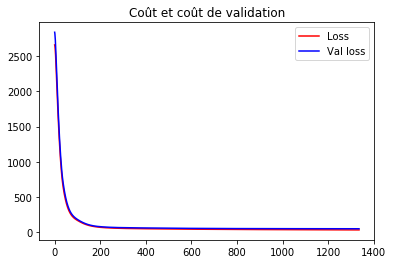

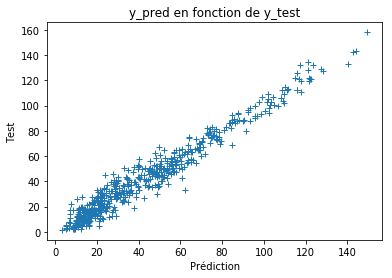

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [13]:
y_test.reshape(len(y_test)).shape

(564,)